In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
# print(plt.style.available)
plt.style.use("ggplot")
# plt.style.use("fivethirtyeight")
plt.style.use("seaborn-talk")

from tqdm import tnrange, tqdm_notebook

In [2]:
def uniform_linear_array(n_mics, spacing):
    return spacing*np.arange(-(n_mics-1)/2, (n_mics-1)/2+1).reshape(1, n_mics)

def compute_MVDR_weight(source_steering_vector, signals):
    snapshot = signals.shape[1]
    sample_covariance_matrix = signals.dot(signals.transpose().conjugate()) / snapshot
    inverse_sample_covariance_matrix = np.linalg.inv(sample_covariance_matrix)
    normalization_factor = (source_steering_vector.transpose().conjugate().dot(inverse_sample_covariance_matrix).dot(source_steering_vector))
    weight = inverse_sample_covariance_matrix.dot(source_steering_vector) / normalization_factor
    return weight

def compute_steering_vector_ULA(u, microphone_array):
    return np.exp(1j*2*np.pi*microphone_array.geometry*u).reshape((microphone_array.n_mics, 1))

def generate_gaussian_samples(power, shape):
    return np.sqrt(power/2)*np.random.randn(shape[0], shape[1]) + 1j*np.sqrt(power/2)*np.random.randn(shape[0], shape[1]); # signal samples

def check_distortless_constraint(weight, source_steering_vector):
    assert(np.abs(weight.transpose().conjugate().dot(source_steering_vector)) - 1 < 1e-9)
    
class MicrophoneArray():
    def __init__(self, array_geometry):
        self.dim = array_geometry.shape[0]
        self.n_mics = array_geometry.shape[1]
        self.geometry = array_geometry

    
        
class BaseDLBeamformer(object):
    def __init__(self, vs, bf_type="MVDR"):
        """
        Parameters
        ----------
        vs: Source manifold array vector
        bf_type: Type of beamformer
        """
        self.vs = vs
        self.bf_type = bf_type
        self.weights_ = None
        
    def _compute_weights(self, training_data):
        n_training_samples = len(training_data)
        n_mics, snapshot = training_data[0].shape
        D = np.zeros((n_mics, n_training_samples), dtype=complex)
        for i_training_sample in range(n_training_samples):
            nv = training_data[i_training_sample]
            if self.bf_type == "MVDR":
                w = compute_MVDR_weight(vs, nv)
#                 check_distortless_constraint(w, self.vs)
            D[:, i_training_sample] = w.reshape(n_mics,)
            
        return D

    def _initialize(self, X):
        pass

    def _choose_weights(self, x):
        n_dictionary_atoms = self.weights_.shape[1]
        R = x.dot(x.transpose().conjugate())
        proxy = np.diagonal(self.weights_.transpose().conjugate().dot(R).dot(self.weights_))
        optimal_weight_index = np.argmin(proxy)
        optimal_weight = self.weights_[:, optimal_weight_index]        
        return optimal_weight, optimal_weight_index
    
    def fit(self, training_data):
        """
        Parameters
        ----------
        X: shape = [n_samples, n_features]
        """
        D = self._compute_weights(training_data)
        self.weights_ = D
        return self

    def choose_weights(self, x):
        return self._choose_weights(x)

#### Setup

In [3]:
array_geometry = uniform_linear_array(n_mics=10, spacing=0.5)
microphone_array = MicrophoneArray(array_geometry)
us = 0
vs = compute_steering_vector_ULA(us, microphone_array)
SNRs = np.arange(0, 31, 10)
n_SNRs = len(SNRs)
sigma_n = 1

In [4]:
microphone_array.geometry.shape

(1, 10)

#### Training data

In [5]:
training_snapshots = [10, 50, 100]
interference_powers = [10, 20, 30]
n_interference_list = [1, 2, 3]
u_step = 0.5
u_list = np.arange(-1, 1+1e-6, u_step)
training_snapshots = [100]
interference_powers = [10]
n_interference_list = [1]

In [6]:
# D = dictionaries[0].weights_
# for i in range(D.shape[1]):
#     check = np.abs(D[:, i].transpose().conjugate().dot(vs))
#     print(i, check)

In [7]:
import itertools
training_noise_interference_data_various_snapshots = []
for training_snapshot in training_snapshots:
    training_noise_interference_data = []
    for n_interferences in n_interference_list:
        interferences_params = []
        for i_interference in range(n_interferences):
            interference_params = list(itertools.product(*[u_list, interference_powers]))
            interferences_params.append(interference_params)
        interferences_param_sets = list(itertools.product(*interferences_params))        

        # for param_set in interferences_param_sets:
        for param_set in interferences_param_sets:
            n_training_samples = 10
            for i_training_sample in range(n_training_samples):
                nv = np.zeros((microphone_array.n_mics, training_snapshot), dtype=complex)
                for i_interference in range(len(param_set)):
                    u, interference_power = param_set[i_interference]
                    vi = compute_steering_vector_ULA(u, microphone_array)
                    sigma = 10**(interference_power/10)
                    ii = generate_gaussian_samples(power=sigma, shape=(1, training_snapshot))
                    nv += vi.dot(ii)
                noise = generate_gaussian_samples(power=sigma_n, shape=(microphone_array.n_mics, training_snapshot))
                nv += noise
                training_noise_interference_data.append(nv)
    training_noise_interference_data_various_snapshots.append(training_noise_interference_data)

#### Train baseline dictionary

In [8]:
dictionaries = []
for i_training_snapshot in range(len(training_snapshots)):
    training_noise_interference_data = training_noise_interference_data_various_snapshots[i_training_snapshot]
    dictionary = BaseDLBeamformer(vs)
    dictionary.fit(training_noise_interference_data);
    dictionaries.append(dictionary)

In [9]:
dictionaries[0].weights_.shape

(10, 50)

#### Testing

In [10]:
n_trials = 100
snapshots = np.array([10, 20, 30, 40, 60, 100, 200, 500, 1000])
n_snapshots = len(snapshots)
ui1 = np.random.uniform(0, 1)
ui2 = np.random.uniform(0, 1)
sigma_1 = 10**(20/10)
sigma_2 = 0*10**(20/10)
vi1 = compute_steering_vector_ULA(ui1, microphone_array)
vi2 = compute_steering_vector_ULA(ui2, microphone_array)



sinr_snr_random = np.zeros((n_SNRs, n_snapshots))
sinr_snr_mvdr = np.zeros((n_SNRs, n_snapshots))
sinr_snr_mpdr = np.zeros((n_SNRs, n_snapshots))
sinr_snr_baseline_mpdr = np.zeros((len(training_snapshots), n_SNRs, n_snapshots))
sinr_snr_baseline_mvdr = np.zeros((len(training_snapshots), n_SNRs, n_snapshots))


for i_SNR in tqdm_notebook(range(n_SNRs), desc="SNRs"):
    sigma_s = 10**(SNRs[i_SNR] / 10)
    Rs = sigma_s * vs.dot(vs.transpose().conjugate())    
    
    for i_snapshot in tqdm_notebook(range(n_snapshots), desc="Snapshots", leave=False):
        snapshot = snapshots[i_snapshot]
        sinr_mvdr = np.zeros(n_trials)
        sinr_mpdr = np.zeros(n_trials)
        sinr_baseline_mpdr = np.zeros((len(training_snapshots), n_trials))
        sinr_baseline_mvdr = np.zeros((len(training_snapshots), n_trials))
        sinr_random = np.zeros(n_trials)
        
        for i_trial in range(n_trials):
            
            ss = generate_gaussian_samples(power=sigma_s, shape=(1, snapshot)) # signal samples
            nn = generate_gaussian_samples(power=sigma_n, shape=(microphone_array.n_mics, snapshot)) # Gaussian noise samples            
            
            n_interferences = np.random.choice(n_interference_list)
            nv = np.zeros((microphone_array.n_mics, snapshot), dtype=complex)
            Rn = np.zeros((microphone_array.n_mics, microphone_array.n_mics), dtype=complex)
            for i_interference in range(n_interferences):
                u = np.random.choice(u_list)
#                 u = np.random.uniform(0, 10)
#                 u = 100
                interference_steering_vector = compute_steering_vector_ULA(u, microphone_array)
                sigma = 10**(np.random.choice(interference_powers)/10)
                ii = generate_gaussian_samples(power=sigma, shape=(1, snapshot))
                nv += interference_steering_vector.dot(ii)
                Rn += sigma*interference_steering_vector.dot(interference_steering_vector.transpose().conjugate())
            Rn += sigma_n*np.identity(microphone_array.n_mics)
            Rninv = np.linalg.inv(Rn)
            Wo = Rninv.dot(vs) / (vs.transpose().conjugate().dot(Rninv).dot(vs))
            SINRopt = ( np.real(Wo.transpose().conjugate().dot(Rs).dot(Wo)) / np.real(Wo.transpose().conjugate().dot(Rn).dot(Wo)) )[0][0]
            
            nv += nn
            sv = vs.dot(ss)
            xx = sv + nv
            
            wv = compute_MVDR_weight(vs, nv)
            check_distortless_constraint(wv, vs)
            wp = compute_MVDR_weight(vs, xx)
            w_random = np.random.randn(microphone_array.geometry.shape[1], 1)
            for i_dictionary in range(len(dictionaries)):
                dictionary = dictionaries[i_dictionary]
                w_baseline_p, w_index_p = dictionary.choose_weights(xx)
                sinr_baseline_mpdr[i_dictionary, i_trial] = np.real(w_baseline_p.transpose().conjugate().dot(Rs).dot(w_baseline_p)) / np.real(w_baseline_p.transpose().conjugate().dot(Rn).dot(w_baseline_p))
                w_baseline_v, w_index_v = dictionary.choose_weights(nv)
                sinr_baseline_mvdr[i_dictionary, i_trial] = np.real(w_baseline_v.transpose().conjugate().dot(Rs).dot(w_baseline_v)) / np.real(w_baseline_v.transpose().conjugate().dot(Rn).dot(w_baseline_v))
#                 print('w_index_p = {}, w_index_v = {}'.format(w_index_p, w_index_v))
            sinr_mvdr[i_trial] = np.real(wv.transpose().conjugate().dot(Rs).dot(wv)) / np.real(wv.transpose().conjugate().dot(Rn).dot(wv))
            sinr_mpdr[i_trial] = np.real(wp.transpose().conjugate().dot(Rs).dot(wp)) / np.real(wp.transpose().conjugate().dot(Rn).dot(wp))
            sinr_random[i_trial] = np.real(w_random.transpose().conjugate().dot(Rs).dot(w_random)) / np.real(w_random.transpose().conjugate().dot(Rn).dot(w_random))
            
        sinr_snr_mvdr[i_SNR, i_snapshot] = np.sum(sinr_mvdr) / n_trials
        sinr_snr_mpdr[i_SNR, i_snapshot] = np.sum(sinr_mpdr) / n_trials
        sinr_snr_random[i_SNR, i_snapshot] = np.sum(sinr_random) / n_trials
        
        for i_dictionary in range(len(dictionaries)):
            sinr_snr_baseline_mpdr[i_dictionary, i_SNR, i_snapshot] = np.sum(sinr_baseline_mpdr[i_dictionary, :]) / n_trials
            sinr_snr_baseline_mvdr[i_dictionary, i_SNR, i_snapshot] = np.sum(sinr_baseline_mvdr[i_dictionary, :]) / n_trials

w_index_p = 5, w_index_v = 21
w_index_p = 20, w_index_v = 29
w_index_p = 11, w_index_v = 18
w_index_p = 11, w_index_v = 48
w_index_p = 2, w_index_v = 5
w_index_p = 41, w_index_v = 32
w_index_p = 42, w_index_v = 7
w_index_p = 38, w_index_v = 9
w_index_p = 0, w_index_v = 0
w_index_p = 9, w_index_v = 48
w_index_p = 11, w_index_v = 14
w_index_p = 6, w_index_v = 31
w_index_p = 41, w_index_v = 46
w_index_p = 34, w_index_v = 34
w_index_p = 35, w_index_v = 7
w_index_p = 28, w_index_v = 28
w_index_p = 30, w_index_v = 49
w_index_p = 31, w_index_v = 44
w_index_p = 0, w_index_v = 37
w_index_p = 18, w_index_v = 36
w_index_p = 37, w_index_v = 16
w_index_p = 41, w_index_v = 13
w_index_p = 37, w_index_v = 46
w_index_p = 42, w_index_v = 39
w_index_p = 19, w_index_v = 6
w_index_p = 14, w_index_v = 39
w_index_p = 0, w_index_v = 39
w_index_p = 41, w_index_v = 12
w_index_p = 10, w_index_v = 41
w_index_p = 22, w_index_v = 22
w_index_p = 13, w_index_v = 48
w_index_p = 23, w_index_v = 23
w_index_p = 34, w_ind

w_index_p = 18, w_index_v = 41
w_index_p = 17, w_index_v = 1
w_index_p = 26, w_index_v = 26
w_index_p = 18, w_index_v = 46
w_index_p = 33, w_index_v = 34
w_index_p = 43, w_index_v = 11
w_index_p = 11, w_index_v = 11
w_index_p = 46, w_index_v = 35
w_index_p = 35, w_index_v = 34
w_index_p = 6, w_index_v = 8
w_index_p = 39, w_index_v = 48
w_index_p = 3, w_index_v = 20
w_index_p = 6, w_index_v = 43
w_index_p = 43, w_index_v = 43
w_index_p = 31, w_index_v = 31
w_index_p = 45, w_index_v = 9
w_index_p = 39, w_index_v = 33
w_index_p = 17, w_index_v = 14
w_index_p = 5, w_index_v = 24
w_index_p = 39, w_index_v = 33
w_index_p = 46, w_index_v = 34
w_index_p = 37, w_index_v = 38
w_index_p = 24, w_index_v = 1
w_index_p = 8, w_index_v = 47
w_index_p = 16, w_index_v = 15
w_index_p = 49, w_index_v = 43
w_index_p = 16, w_index_v = 11
w_index_p = 9, w_index_v = 45
w_index_p = 8, w_index_v = 8
w_index_p = 19, w_index_v = 44
w_index_p = 39, w_index_v = 39
w_index_p = 17, w_index_v = 17
w_index_p = 12, w_in

w_index_p = 36, w_index_v = 39
w_index_p = 5, w_index_v = 5
w_index_p = 7, w_index_v = 40
w_index_p = 35, w_index_v = 34
w_index_p = 8, w_index_v = 40
w_index_p = 7, w_index_v = 9
w_index_p = 49, w_index_v = 2
w_index_p = 19, w_index_v = 11
w_index_p = 30, w_index_v = 30
w_index_p = 19, w_index_v = 11
w_index_p = 11, w_index_v = 41
w_index_p = 36, w_index_v = 0
w_index_p = 41, w_index_v = 9
w_index_p = 44, w_index_v = 40
w_index_p = 43, w_index_v = 43
w_index_p = 34, w_index_v = 39
w_index_p = 10, w_index_v = 12
w_index_p = 43, w_index_v = 44
w_index_p = 37, w_index_v = 18
w_index_p = 13, w_index_v = 11
w_index_p = 49, w_index_v = 40
w_index_p = 7, w_index_v = 7
w_index_p = 39, w_index_v = 33
w_index_p = 8, w_index_v = 40
w_index_p = 36, w_index_v = 39
w_index_p = 45, w_index_v = 40
w_index_p = 19, w_index_v = 11
w_index_p = 37, w_index_v = 38
w_index_p = 41, w_index_v = 9
w_index_p = 15, w_index_v = 16
w_index_p = 17, w_index_v = 17
w_index_p = 41, w_index_v = 40
w_index_p = 36, w_ind

w_index_p = 32, w_index_v = 18
w_index_p = 34, w_index_v = 38
w_index_p = 35, w_index_v = 35
w_index_p = 6, w_index_v = 45
w_index_p = 14, w_index_v = 43
w_index_p = 17, w_index_v = 32
w_index_p = 24, w_index_v = 24
w_index_p = 10, w_index_v = 6
w_index_p = 39, w_index_v = 43
w_index_p = 24, w_index_v = 31
w_index_p = 36, w_index_v = 15
w_index_p = 13, w_index_v = 44
w_index_p = 44, w_index_v = 40
w_index_p = 10, w_index_v = 14
w_index_p = 46, w_index_v = 15
w_index_p = 26, w_index_v = 45
w_index_p = 35, w_index_v = 42
w_index_p = 39, w_index_v = 46
w_index_p = 32, w_index_v = 48
w_index_p = 49, w_index_v = 12
w_index_p = 18, w_index_v = 35
w_index_p = 26, w_index_v = 26
w_index_p = 18, w_index_v = 31
w_index_p = 6, w_index_v = 3
w_index_p = 11, w_index_v = 4
w_index_p = 25, w_index_v = 17
w_index_p = 18, w_index_v = 11
w_index_p = 11, w_index_v = 16
w_index_p = 6, w_index_v = 41
w_index_p = 32, w_index_v = 48
w_index_p = 37, w_index_v = 3
w_index_p = 26, w_index_v = 0
w_index_p = 20, 

w_index_p = 14, w_index_v = 33
w_index_p = 1, w_index_v = 18
w_index_p = 33, w_index_v = 15
w_index_p = 17, w_index_v = 12
w_index_p = 13, w_index_v = 9
w_index_p = 7, w_index_v = 41
w_index_p = 39, w_index_v = 35
w_index_p = 14, w_index_v = 12
w_index_p = 1, w_index_v = 38
w_index_p = 36, w_index_v = 36
w_index_p = 7, w_index_v = 16
w_index_p = 24, w_index_v = 39
w_index_p = 17, w_index_v = 46
w_index_p = 37, w_index_v = 45
w_index_p = 13, w_index_v = 1
w_index_p = 41, w_index_v = 18
w_index_p = 32, w_index_v = 41
w_index_p = 26, w_index_v = 23
w_index_p = 22, w_index_v = 4
w_index_p = 37, w_index_v = 11
w_index_p = 29, w_index_v = 19
w_index_p = 18, w_index_v = 39
w_index_p = 2, w_index_v = 43
w_index_p = 30, w_index_v = 0
w_index_p = 34, w_index_v = 47
w_index_p = 48, w_index_v = 9
w_index_p = 42, w_index_v = 43
w_index_p = 26, w_index_v = 26
w_index_p = 12, w_index_v = 44
w_index_p = 25, w_index_v = 27
w_index_p = 41, w_index_v = 15
w_index_p = 46, w_index_v = 10
w_index_p = 47, w_

w_index_p = 48, w_index_v = 1
w_index_p = 33, w_index_v = 38
w_index_p = 4, w_index_v = 44
w_index_p = 48, w_index_v = 40
w_index_p = 18, w_index_v = 40
w_index_p = 7, w_index_v = 40
w_index_p = 45, w_index_v = 40
w_index_p = 14, w_index_v = 14
w_index_p = 8, w_index_v = 49
w_index_p = 30, w_index_v = 34
w_index_p = 19, w_index_v = 42
w_index_p = 40, w_index_v = 43
w_index_p = 0, w_index_v = 40
w_index_p = 34, w_index_v = 33
w_index_p = 41, w_index_v = 16
w_index_p = 41, w_index_v = 39
w_index_p = 31, w_index_v = 34
w_index_p = 35, w_index_v = 35
w_index_p = 6, w_index_v = 9
w_index_p = 13, w_index_v = 16
w_index_p = 18, w_index_v = 11
w_index_p = 44, w_index_v = 9
w_index_p = 38, w_index_v = 38
w_index_p = 38, w_index_v = 39
w_index_p = 11, w_index_v = 16
w_index_p = 34, w_index_v = 11
w_index_p = 45, w_index_v = 9
w_index_p = 34, w_index_v = 39
w_index_p = 45, w_index_v = 40
w_index_p = 48, w_index_v = 40
w_index_p = 42, w_index_v = 40
w_index_p = 30, w_index_v = 39
w_index_p = 49, w

w_index_p = 28, w_index_v = 16
w_index_p = 22, w_index_v = 39
w_index_p = 21, w_index_v = 35
w_index_p = 26, w_index_v = 10
w_index_p = 36, w_index_v = 40
w_index_p = 20, w_index_v = 26
w_index_p = 20, w_index_v = 12
w_index_p = 24, w_index_v = 39
w_index_p = 29, w_index_v = 14
w_index_p = 22, w_index_v = 22
w_index_p = 22, w_index_v = 48
w_index_p = 21, w_index_v = 15
w_index_p = 29, w_index_v = 12
w_index_p = 28, w_index_v = 6
w_index_p = 28, w_index_v = 43
w_index_p = 26, w_index_v = 29
w_index_p = 23, w_index_v = 15
w_index_p = 29, w_index_v = 24
w_index_p = 17, w_index_v = 40
w_index_p = 30, w_index_v = 43
w_index_p = 21, w_index_v = 29
w_index_p = 20, w_index_v = 15
w_index_p = 20, w_index_v = 19
w_index_p = 22, w_index_v = 22
w_index_p = 29, w_index_v = 28
w_index_p = 22, w_index_v = 33
w_index_p = 20, w_index_v = 6
w_index_p = 25, w_index_v = 13
w_index_p = 32, w_index_v = 4
w_index_p = 20, w_index_v = 14
w_index_p = 24, w_index_v = 27
w_index_p = 25, w_index_v = 45
w_index_p =

w_index_p = 36, w_index_v = 49
w_index_p = 17, w_index_v = 38
w_index_p = 41, w_index_v = 14
w_index_p = 22, w_index_v = 1
w_index_p = 24, w_index_v = 36
w_index_p = 22, w_index_v = 5
w_index_p = 17, w_index_v = 45
w_index_p = 28, w_index_v = 33
w_index_p = 42, w_index_v = 45
w_index_p = 17, w_index_v = 1
w_index_p = 23, w_index_v = 20
w_index_p = 24, w_index_v = 21
w_index_p = 25, w_index_v = 49
w_index_p = 24, w_index_v = 13
w_index_p = 31, w_index_v = 9
w_index_p = 13, w_index_v = 40
w_index_p = 4, w_index_v = 45
w_index_p = 37, w_index_v = 8
w_index_p = 45, w_index_v = 3
w_index_p = 24, w_index_v = 35
w_index_p = 6, w_index_v = 37
w_index_p = 41, w_index_v = 6
w_index_p = 23, w_index_v = 37
w_index_p = 26, w_index_v = 31
w_index_p = 17, w_index_v = 44
w_index_p = 24, w_index_v = 35
w_index_p = 25, w_index_v = 13
w_index_p = 30, w_index_v = 45
w_index_p = 20, w_index_v = 22
w_index_p = 26, w_index_v = 26
w_index_p = 25, w_index_v = 16
w_index_p = 26, w_index_v = 2
w_index_p = 23, w_

w_index_p = 41, w_index_v = 39
w_index_p = 35, w_index_v = 40
w_index_p = 6, w_index_v = 44
w_index_p = 11, w_index_v = 40
w_index_p = 47, w_index_v = 31
w_index_p = 32, w_index_v = 40
w_index_p = 46, w_index_v = 34
w_index_p = 1, w_index_v = 0
w_index_p = 39, w_index_v = 11
w_index_p = 19, w_index_v = 15
w_index_p = 18, w_index_v = 11
w_index_p = 34, w_index_v = 46
w_index_p = 16, w_index_v = 11
w_index_p = 5, w_index_v = 13
w_index_p = 35, w_index_v = 38
w_index_p = 17, w_index_v = 9
w_index_p = 4, w_index_v = 12
w_index_p = 17, w_index_v = 43
w_index_p = 46, w_index_v = 9
w_index_p = 24, w_index_v = 10
w_index_p = 17, w_index_v = 40
w_index_p = 19, w_index_v = 30
w_index_p = 19, w_index_v = 11
w_index_p = 35, w_index_v = 33
w_index_p = 27, w_index_v = 46
w_index_p = 6, w_index_v = 40
w_index_p = 14, w_index_v = 40
w_index_p = 11, w_index_v = 44
w_index_p = 49, w_index_v = 9
w_index_p = 40, w_index_v = 11
w_index_p = 10, w_index_v = 11
w_index_p = 16, w_index_v = 40
w_index_p = 42, w

w_index_p = 25, w_index_v = 32
w_index_p = 28, w_index_v = 45
w_index_p = 27, w_index_v = 41
w_index_p = 23, w_index_v = 10
w_index_p = 28, w_index_v = 10
w_index_p = 29, w_index_v = 46
w_index_p = 27, w_index_v = 44
w_index_p = 21, w_index_v = 21
w_index_p = 24, w_index_v = 9
w_index_p = 21, w_index_v = 13
w_index_p = 24, w_index_v = 34
w_index_p = 27, w_index_v = 15
w_index_p = 26, w_index_v = 13
w_index_p = 27, w_index_v = 31
w_index_p = 26, w_index_v = 7
w_index_p = 29, w_index_v = 31
w_index_p = 28, w_index_v = 32
w_index_p = 20, w_index_v = 33
w_index_p = 21, w_index_v = 7
w_index_p = 24, w_index_v = 48
w_index_p = 24, w_index_v = 28
w_index_p = 21, w_index_v = 13
w_index_p = 23, w_index_v = 42
w_index_p = 29, w_index_v = 7
w_index_p = 27, w_index_v = 6
w_index_p = 22, w_index_v = 15
w_index_p = 29, w_index_v = 38
w_index_p = 23, w_index_v = 12
w_index_p = 23, w_index_v = 37
w_index_p = 25, w_index_v = 2
w_index_p = 20, w_index_v = 20
w_index_p = 20, w_index_v = 42
w_index_p = 26

w_index_p = 23, w_index_v = 8
w_index_p = 13, w_index_v = 43
w_index_p = 22, w_index_v = 2
w_index_p = 24, w_index_v = 13
w_index_p = 22, w_index_v = 3
w_index_p = 23, w_index_v = 5
w_index_p = 28, w_index_v = 7
w_index_p = 21, w_index_v = 43
w_index_p = 23, w_index_v = 25
w_index_p = 29, w_index_v = 39
w_index_p = 28, w_index_v = 26
w_index_p = 22, w_index_v = 32
w_index_p = 23, w_index_v = 23
w_index_p = 6, w_index_v = 35
w_index_p = 23, w_index_v = 46
w_index_p = 26, w_index_v = 39
w_index_p = 27, w_index_v = 35
w_index_p = 20, w_index_v = 24
w_index_p = 21, w_index_v = 6
w_index_p = 20, w_index_v = 33
w_index_p = 23, w_index_v = 30
w_index_p = 24, w_index_v = 46
w_index_p = 25, w_index_v = 47
w_index_p = 29, w_index_v = 36
w_index_p = 20, w_index_v = 9
w_index_p = 26, w_index_v = 16
w_index_p = 27, w_index_v = 39
w_index_p = 21, w_index_v = 45
w_index_p = 24, w_index_v = 33
w_index_p = 23, w_index_v = 43
w_index_p = 22, w_index_v = 43
w_index_p = 28, w_index_v = 40
w_index_p = 22, 

w_index_p = 25, w_index_v = 38
w_index_p = 20, w_index_v = 24
w_index_p = 29, w_index_v = 0
w_index_p = 24, w_index_v = 38
w_index_p = 28, w_index_v = 2
w_index_p = 27, w_index_v = 31
w_index_p = 22, w_index_v = 15
w_index_p = 22, w_index_v = 44
w_index_p = 26, w_index_v = 45
w_index_p = 22, w_index_v = 10
w_index_p = 26, w_index_v = 9
w_index_p = 41, w_index_v = 17
w_index_p = 27, w_index_v = 40
w_index_p = 28, w_index_v = 19
w_index_p = 25, w_index_v = 11
w_index_p = 26, w_index_v = 14
w_index_p = 37, w_index_v = 41
w_index_p = 22, w_index_v = 39
w_index_p = 24, w_index_v = 13
w_index_p = 28, w_index_v = 40
w_index_p = 32, w_index_v = 9
w_index_p = 28, w_index_v = 17
w_index_p = 27, w_index_v = 7
w_index_p = 27, w_index_v = 2
w_index_p = 22, w_index_v = 8
w_index_p = 21, w_index_v = 12
w_index_p = 23, w_index_v = 11
w_index_p = 26, w_index_v = 10
w_index_p = 29, w_index_v = 11
w_index_p = 21, w_index_v = 35
w_index_p = 27, w_index_v = 9
w_index_p = 26, w_index_v = 46
w_index_p = 29, 

w_index_p = 36, w_index_v = 40
w_index_p = 13, w_index_v = 44
w_index_p = 36, w_index_v = 9
w_index_p = 13, w_index_v = 44
w_index_p = 26, w_index_v = 5
w_index_p = 19, w_index_v = 44
w_index_p = 11, w_index_v = 40
w_index_p = 7, w_index_v = 40
w_index_p = 13, w_index_v = 9
w_index_p = 35, w_index_v = 11
w_index_p = 30, w_index_v = 40
w_index_p = 30, w_index_v = 40
w_index_p = 1, w_index_v = 43
w_index_p = 24, w_index_v = 16
w_index_p = 25, w_index_v = 40
w_index_p = 6, w_index_v = 34
w_index_p = 4, w_index_v = 38
w_index_p = 25, w_index_v = 12
w_index_p = 13, w_index_v = 40
w_index_p = 27, w_index_v = 16
w_index_p = 32, w_index_v = 40
w_index_p = 14, w_index_v = 40
w_index_p = 24, w_index_v = 34
w_index_p = 18, w_index_v = 39
w_index_p = 26, w_index_v = 40
w_index_p = 24, w_index_v = 11
w_index_p = 3, w_index_v = 9
w_index_p = 24, w_index_v = 11
w_index_p = 25, w_index_v = 40
w_index_p = 39, w_index_v = 44
w_index_p = 24, w_index_v = 34
w_index_p = 23, w_index_v = 40
w_index_p = 17, w

#### Visualize results

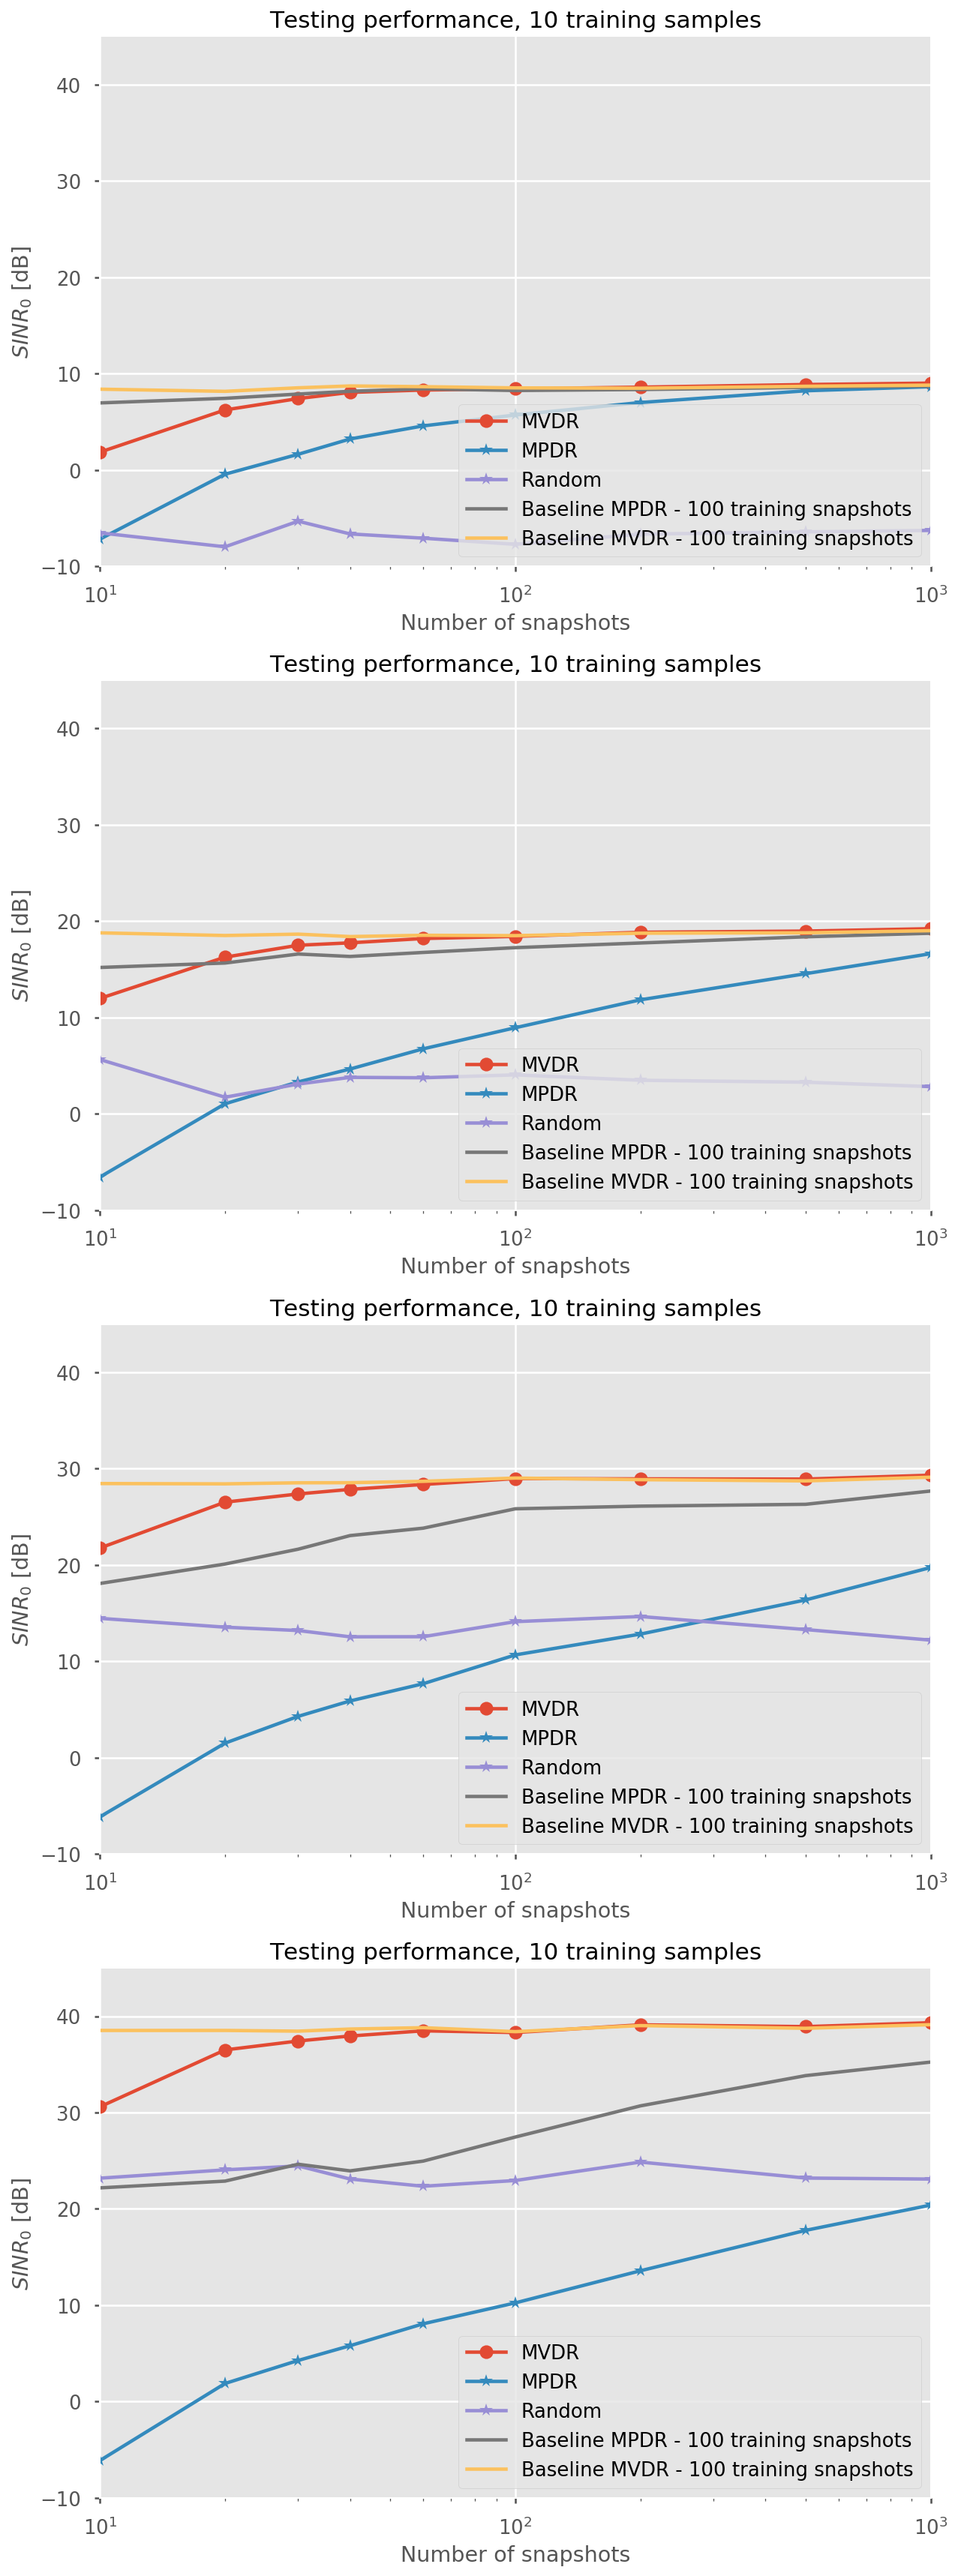

In [11]:
fig = plt.figure(figsize=(9, 6*n_SNRs)); 
for i_SNR in range(n_SNRs):
    sigma_s = 10**(SNRs[i_SNR] / 10)
    Rs = sigma_s * vs.dot(vs.transpose().conjugate())
    
    SINRopt = ( np.real(Wo.transpose().conjugate().dot(Rs).dot(Wo)) / np.real(Wo.transpose().conjugate().dot(Rn).dot(Wo)) )[0][0]
    ax = fig.add_subplot(n_SNRs, 1, i_SNR+1)
    ax.semilogx(snapshots, 10*np.log10(sinr_snr_mvdr[i_SNR, :]), marker="o", label="MVDR")
    ax.semilogx(snapshots, 10*np.log10(sinr_snr_mpdr[i_SNR, :]), marker="*", label="MPDR")
    ax.semilogx(snapshots, 10*np.log10(sinr_snr_random[i_SNR, :]), marker="*", label="Random")
    for i_training_snapshot in range(len(training_snapshots)):
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mpdr[i_training_snapshot, i_SNR, :]), 
                    label="Baseline MPDR - {} training snapshots".format(training_snapshots[i_training_snapshot]))
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mvdr[i_training_snapshot, i_SNR, :]), 
                    label="Baseline MVDR - {} training snapshots".format(training_snapshots[i_training_snapshot]))
    ax.set_xlim(10, 1000); ax.set_ylim(-10, 45)
    ax.legend(loc="lower right")
    ax.set_xlabel("Number of snapshots")
    ax.set_ylabel(r"$SINR_0$ [dB]")
    ax.set_title("Testing performance, {} training samples".format(n_training_samples))
plt.tight_layout()
# fig.savefig("baseline_dl_mvdr_various_interferences.jpg", dpi=600)

In [12]:
Rshat = sv.dot(sv.transpose().conjugate())
Rshat2 = ss.dot(ss.transpose().conjugate())
np.linalg.norm(Rshat - Rshat2)

1.1641532182693481e-09

In [13]:
Rshat

array([[976946.52490946+0.j, 976946.52490946+0.j, 976946.52490946+0.j,
        976946.52490946+0.j, 976946.52490946+0.j, 976946.52490946+0.j,
        976946.52490946+0.j, 976946.52490946+0.j, 976946.52490946+0.j,
        976946.52490946+0.j],
       [976946.52490946+0.j, 976946.52490946+0.j, 976946.52490946+0.j,
        976946.52490946+0.j, 976946.52490946+0.j, 976946.52490946+0.j,
        976946.52490946+0.j, 976946.52490946+0.j, 976946.52490946+0.j,
        976946.52490946+0.j],
       [976946.52490946+0.j, 976946.52490946+0.j, 976946.52490946+0.j,
        976946.52490946+0.j, 976946.52490946+0.j, 976946.52490946+0.j,
        976946.52490946+0.j, 976946.52490946+0.j, 976946.52490946+0.j,
        976946.52490946+0.j],
       [976946.52490946+0.j, 976946.52490946+0.j, 976946.52490946+0.j,
        976946.52490946+0.j, 976946.52490946+0.j, 976946.52490946+0.j,
        976946.52490946+0.j, 976946.52490946+0.j, 976946.52490946+0.j,
        976946.52490946+0.j],
       [976946.52490946+0.j,

In [14]:
dictionary.weights_.shape
for i in range(dictionary.weights_.shape[1]):
    weight = dictionary.weights_[:, i]
    print(np.abs(weight.transpose().conjugate().dot(Rshat).dot(weight)))

976946.5249094599
976946.52490946
976946.52490946
976946.5249094599
976946.5249094598
976946.5249094596
976946.5249094594
976946.5249094593
976946.5249094599
976946.5249094595
976946.5249094595
976946.5249094594
976946.5249094595
976946.5249094598
976946.5249094596
976946.5249094594
976946.5249094594
976946.52490946
976946.5249094594
976946.5249094596
976946.5249094625
976946.5249094623
976946.524909467
976946.524909465
976946.5249094586
976946.5249094637
976946.5249094539
976946.5249094594
976946.5249094575
976946.524909463
976946.5249094599
976946.5249094593
976946.5249094592
976946.5249094592
976946.5249094598
976946.5249094598
976946.5249094599
976946.5249094593
976946.5249094598
976946.5249094593
976946.5249094598
976946.5249094599
976946.5249094592
976946.5249094596
976946.5249094595
976946.5249094599
976946.5249094598
976946.5249094594
976946.5249094599
976946.5249094598


In [15]:
xx = sv + nv
Rxx = xx.dot(xx.transpose().conjugate())
Rsv = sv.dot(sv.transpose().conjugate())
Rnv = nv.dot(nv.transpose().conjugate())
np.linalg.norm(Rxx - Rsv - Rnv)

19493.950366723147

In [16]:
np.abs(sv.dot(nv.transpose().conjugate()))

array([[ 770.64757125,  774.02572767, 1737.77910497, 1092.63874183,
        1372.04894376, 1167.58490464, 2574.4268801 ,  838.6494375 ,
         676.66050506, 1511.54165949],
       [ 770.64757125,  774.02572767, 1737.77910497, 1092.63874183,
        1372.04894376, 1167.58490464, 2574.4268801 ,  838.6494375 ,
         676.66050506, 1511.54165949],
       [ 770.64757125,  774.02572767, 1737.77910497, 1092.63874183,
        1372.04894376, 1167.58490464, 2574.4268801 ,  838.6494375 ,
         676.66050506, 1511.54165949],
       [ 770.64757125,  774.02572767, 1737.77910497, 1092.63874183,
        1372.04894376, 1167.58490464, 2574.4268801 ,  838.6494375 ,
         676.66050506, 1511.54165949],
       [ 770.64757125,  774.02572767, 1737.77910497, 1092.63874183,
        1372.04894376, 1167.58490464, 2574.4268801 ,  838.6494375 ,
         676.66050506, 1511.54165949],
       [ 770.64757125,  774.02572767, 1737.77910497, 1092.63874183,
        1372.04894376, 1167.58490464, 2574.4268801 ,  838

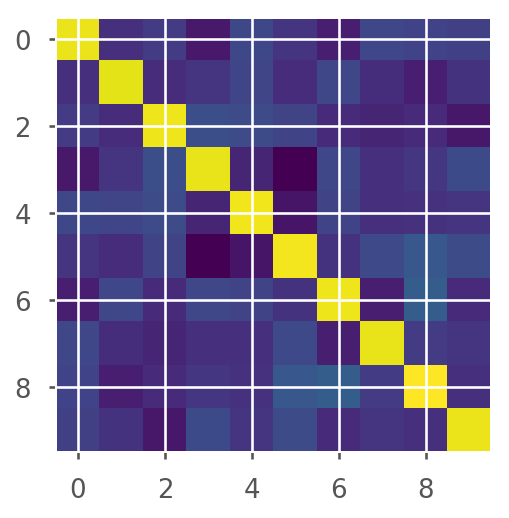

In [21]:
A = np.linalg.inv(Rnv)
plt.imshow(np.log(np.abs(A)))